In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CS224W - Colab 5**

In this Colab we will experiment on scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. As we have **canceled** the Colab 5 assignment, this notebook will be a tutorial and you do not need to submit it on Gradescope.  
在这个 Colab 中，我们将尝试使用 PyTorch Geometric、DeepSNAP 和 NetworkX 来扩展 GNN。 由于我们取消了 Colab 5 作业，此笔记本将作为教程，您无需在 Gradescope 上提交。

At first, we will use PyTorch Geometric `NeighborSampler` to scale up the training and testing on OGB `arxiv` dataset.  
首先，我们将使用 PyTorch Geometric NeighborSampler 来扩大 OGB arxiv 数据集的训练和测试。

Then, using the DeepSNAP and NetworkX, we will implement a simplified version of `NeighborSampler` and run experiments with different smapling ratios on the Cora graph.  
然后，使用 DeepSNAP 和 NetworkX，我们将实现 NeighborSampler 的简化版本，并在 Cora 图上运行不同采样率的实验。

At last, we will partition the Cora graph into clusters by using different partition algorithms and then train the models in the way of vanilla Cluster-GCN.  
最后，我们将使用不同的划分算法将 Cora 图划分为簇，然后以 vanilla Cluster-GCN 的方式训练模型。

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell  
注意：确保顺序运行每个部分中的所有单元格，以便中间变量/包会延续到下一个单元格

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0+cu102


In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html       # 1.8.0+cu101
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q ogb
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 8.9MB/s 
     |████████████████████████████████| 1.4MB 7.0MB/s 
     |████████████████████████████████| 225kB 31.1MB/s 
     |████████████████████████████████| 235kB 52.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 


In [4]:
import torch_geometric
torch_geometric.__version__

'1.7.2'

# 1 PyTorch Geometric Neighbor SamplingPyTorch  
几何邻域采样

Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As what we have learned in lecture, only a K-hop neighborhood nodes will be loaded into GPU for each time training. To further reduce the cost, we can sample a subset of neighborhood nodes for GNNs to aggregate.  
Neighbor Sampling 最初在 GraphSAGE (Hamilton et al. (2017)) 中提出，是一种扩展 GNN 的代表性方法。 正如我们在讲座中学到的，每次训练只会将一个 K-hop 邻域节点加载到 GPU 中。 为了进一步降低成本，我们可以对 GNN 的邻域节点子集进行采样以进行聚合。

## Setup

In [5]:
import copy
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.data import NeighborSampler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Neighbor Sampler  
邻居采样器

PyTorch Geometric has implemented the Neighbor Sampling method as the [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.NeighborSampler) in `torch_geometric.data`. Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset.  
PyTorch Geometric 在 torch_geometric.data 中实现了 Neighbor Sampling 方法作为 NeighborSampler。 以下是使用邻居采样方法训练 OGB arxiv 数据集的示例。

If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).  
如果您对内存高效聚合感兴趣，请参阅 PyG 的内存高效聚合。

In [6]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

# Construct the training dataloader for training data
# Sample 10 neighbors for each node in the first layer and 5 for the second layer
train_loader = NeighborSampler(data.adj_t, node_idx=train_idx,
                               sizes=[10, 5], batch_size=4096,
                               shuffle=True, num_workers=2)

# Specify size as -1 to include all neighbors
all_loader = NeighborSampler(data.adj_t, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=2)
evaluator = Evaluator(name='ogbn-arxiv')

  0%|          | 0/81 [00:00<?, ?it/s]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:07<00:00, 11.33it/s]


Extracting dataset/arxiv.zip
Processing...
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 125.71it/s]

Processing graphs...
Converting graphs into PyG objects...
Saving...
Done!


Device: cuda


## GNN Model

After creating the `NeighborSampler`, we also need to modify the model to let it support the mini-batch training.  
创建 NeighborSampler 后，我们还需要修改模型以使其支持 mini-batch 训练。

The `forward` function will take the node feature `x` and a list of three-element tuples `adjs`. Each element in `adjs` contains following elements:  
forward 函数将采用节点特征 x 和三元素元组 adjs 的列表。 adjs 中的每个元素都包含以下元素：
* `edge_index`: The edge index tensor between source and destination nodes, which forms a bipartite grpah.  
源节点和目的节点之间的边索引张量，形成二部grpah。
* `e_id`: The indices of the edges in the original graph.  
原始图中边的索引。
* `size`: The shape of the bipartite graph, in (*number of source nodes*, *number of destination nodes*) format.  
二部图的形状，采用（源节点数，目标节点数）格式。

In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adjs, mode="batch"):
        if mode == "batch":
            for i, (edge_index, _, size) in enumerate(adjs):
                # Extract target node features
                x_target = x[:size[1]]

                # Update x for next layer reuse
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        else:
            for i, conv in enumerate(self.convs):
                x = conv(x, adjs)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        return self.softmax(x)
    
    def inference(self, x_all, all_loader):
        # This function will be called in test
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in all_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
                
                # Append the node embeddings to xs
                xs.append(x.cpu())
            
            # Concat all embeddings into one tensor
            x_all = torch.cat(xs, dim=0)

        return x_all

## Training and Testing

Now lets implement the training and testing functions.  
现在让我们实现训练和测试功能。

In both training and testing, we need to sample batch from the dataloader.  
在训练和测试中，我们都需要从数据加载器中采样批次。

Each batch in the `NeighborSampler` dataloader holds three elements:  
NeighborSampler 数据加载器中的每个批次都包含三个元素：
* `batch_size`: The batch size specified in the dataloader.  
数据加载器中指定的批量大小。
* `n_id`: All nodes (in index format) used in the adjacency matrices.  
邻接矩阵中使用的所有节点（以索引格式）。
* `adjs`: The three-element tuples.  
三元素元组。

In [9]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":
        for batch_size, n_id, adjs in train_loader:
            # Move all adj sparse tensors to GPU
            adjs = [adj.to(device) for adj in adjs]
            optimizer.zero_grad()

            # Index on the node features
            out = model(data.x[n_id], adjs)
            train_label = data.y[n_id[:batch_size]].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t, mode=mode)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch"):
    model.eval()

    if mode == "batch":
        out = model.inference(data.x, all_loader)
    else:
        out = model(data.x, data.adj_t, mode="all")

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

## Mini-batch Training

In [10]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

batch_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
batch_model.reset_parameters()

optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_batch_model = None
best_valid_acc = 0

batch_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(batch_model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch")
    result = test(batch_model, data, all_loader, split_idx, evaluator, mode="batch")
    batch_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_batch_model = copy.deepcopy(batch_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_batch_model, data, all_loader, split_idx, evaluator, mode="batch")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 39.3703, Train: 63.85%, Valid: 65.23% Test: 64.97%
Epoch: 02, Loss: 28.3514, Train: 67.54%, Valid: 67.63% Test: 66.24%
Epoch: 03, Loss: 26.3784, Train: 69.18%, Valid: 68.08% Test: 66.21%
Epoch: 04, Loss: 25.5800, Train: 69.99%, Valid: 69.20% Test: 68.14%
Epoch: 05, Loss: 25.0059, Train: 70.67%, Valid: 69.49% Test: 68.30%
Epoch: 06, Loss: 24.5401, Train: 70.40%, Valid: 67.80% Test: 65.43%
Epoch: 07, Loss: 24.2697, Train: 71.58%, Valid: 69.68% Test: 68.26%
Epoch: 08, Loss: 23.8350, Train: 71.69%, Valid: 69.32% Test: 67.72%
Epoch: 09, Loss: 23.6601, Train: 72.05%, Valid: 69.23% Test: 67.48%
Epoch: 10, Loss: 23.5189, Train: 72.26%, Valid: 70.08% Test: 68.56%
Epoch: 11, Loss: 23.4073, Train: 72.33%, Valid: 69.90% Test: 68.46%
Epoch: 12, Loss: 23.0950, Train: 72.44%, Valid: 69.66% Test: 68.30%
Epoch: 13, Loss: 22.9170, Train: 73.21%, Valid: 70.61% Test: 69.83%
Epoch: 14, Loss: 22.7868, Train: 72.72%, Valid: 70.22% Test: 69.30%
Epoch: 15, Loss: 22.7901, Train: 73.11%, Valid: 

## Full-batch Training

In [11]:
# Use the same parameters for a full-batch training
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

all_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
all_model.reset_parameters()

optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_all_model = None
best_valid_acc = 0

all_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(all_model, data, train_loader, train_idx, optimizer, loss_fn, mode="all")
    result = test(all_model, data, all_loader, split_idx, evaluator, mode="all")
    all_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_all_model = copy.deepcopy(all_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_all_model, data, all_loader, split_idx, evaluator, mode="all")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.9031, Train: 32.92%, Valid: 36.75% Test: 35.49%
Epoch: 02, Loss: 2.5733, Train: 34.25%, Valid: 40.33% Test: 41.04%
Epoch: 03, Loss: 2.1980, Train: 35.04%, Valid: 42.83% Test: 45.61%
Epoch: 04, Loss: 2.0146, Train: 34.31%, Valid: 41.84% Test: 45.63%
Epoch: 05, Loss: 1.8865, Train: 35.33%, Valid: 40.81% Test: 44.89%
Epoch: 06, Loss: 1.7832, Train: 39.03%, Valid: 42.99% Test: 46.92%
Epoch: 07, Loss: 1.7004, Train: 43.84%, Valid: 47.43% Test: 50.72%
Epoch: 08, Loss: 1.6363, Train: 47.54%, Valid: 51.19% Test: 53.67%
Epoch: 09, Loss: 1.5798, Train: 50.09%, Valid: 53.91% Test: 55.75%
Epoch: 10, Loss: 1.5259, Train: 51.94%, Valid: 55.73% Test: 57.65%
Epoch: 11, Loss: 1.4750, Train: 53.29%, Valid: 57.06% Test: 58.85%
Epoch: 12, Loss: 1.4467, Train: 54.56%, Valid: 57.80% Test: 59.80%
Epoch: 13, Loss: 1.4225, Train: 55.80%, Valid: 58.78% Test: 60.45%
Epoch: 14, Loss: 1.4013, Train: 57.14%, Valid: 59.82% Test: 61.21%
Epoch: 15, Loss: 1.3842, Train: 58.51%, Valid: 61.05% Test: 62

## Visualization

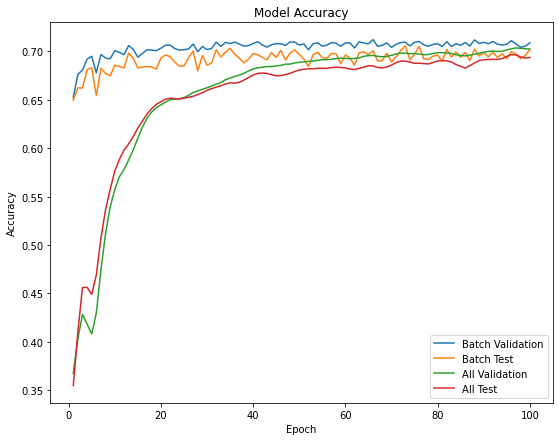

In [12]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_results)
all_results = np.array(all_results)

x = np.arange(1, 101)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 1], label="Batch Validation")
plt.plot(x, batch_results[:, 2], label="Batch Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 2 Neighbor Sampling with Different Ratios  
不同比率的邻域采样

Now we will implement a simplified version of Neighbor Sampling by using DeepSNAP and NetworkX, and train models with different neighborhood sampling ratios.  
现在我们将使用 DeepSNAP 和 NetworkX 实现一个简化版的 Neighbor Sampling，并训练具有不同邻域采样率的模型。

To make the experiments faster, we will use the Cora graph here.  
为了使实验更快，我们将在这里使用 Cora 图。

## Setup

In [13]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./tmp', "Cora")

Processing...
Done!


## GNN Model

In [14]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

## Neighbor Sampling  
邻域采样

Here we implement functions that will sample neighbors by using DeepSNAP and NetworkX.  
在这里，我们实现了使用 DeepSNAP 和 NetworkX 对邻居进行采样的函数。

Notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.  
注意 Cora 上的节点分类任务是一个半监督的分类任务，这里我们通过将最后一个比率设置为 1 来保留所有标记的训练节点（140 个节点）。

In [16]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between 
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor 
    # sampling ratios for each layer. This function returns relabeled node feature, 
    # edge indices and node_label_index

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)
    
    # Reverse the lists
    nodes_list.reverse()
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index

## Training and Testing

In [17]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model):
    model.eval()
    accs = []
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    return accs

In [18]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

## Full-Batch Training

In [19]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0298, Train: 43.57%, Valid: 22.20% Test: 21.90%
Epoch: 02, Loss: 1.1637, Train: 87.86%, Valid: 37.60% Test: 39.70%
Epoch: 03, Loss: 0.6293, Train: 97.14%, Valid: 46.60% Test: 48.90%
Epoch: 04, Loss: 0.3315, Train: 100.00%, Valid: 54.60% Test: 54.40%
Epoch: 05, Loss: 0.1911, Train: 100.00%, Valid: 58.80% Test: 59.40%
Epoch: 06, Loss: 0.0921, Train: 100.00%, Valid: 61.00% Test: 64.20%
Epoch: 07, Loss: 0.0438, Train: 100.00%, Valid: 63.00% Test: 66.10%
Epoch: 08, Loss: 0.0251, Train: 100.00%, Valid: 64.20% Test: 67.40%
Epoch: 09, Loss: 0.0147, Train: 100.00%, Valid: 65.40% Test: 68.80%
Epoch: 10, Loss: 0.0068, Train: 100.00%, Valid: 66.40% Test: 69.20%
Epoch: 11, Loss: 0.0061, Train: 100.00%, Valid: 67.40% Test: 69.80%
Epoch: 12, Loss: 0.0032, Train: 100.00%, Valid: 68.20% Test: 70.30%
Epoch: 13, Loss: 0.0029, Train: 100.00%, Valid: 68.60% Test: 70.40%
Epoch: 14, Loss: 0.0

## Sampling with Ratios 0.8

In [20]:
args['ratios'] = (0.8, 0.8, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 1324 nodes, 2005 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0120, Train: 14.29%, Valid: 12.20% Test: 13.00%
Sampled 1347 nodes, 2038 edges, 140 labeled nodes
Epoch: 02, Loss: 1.6709, Train: 33.57%, Valid: 14.20% Test: 16.60%
Sampled 1306 nodes, 1951 edges, 140 labeled nodes
Epoch: 03, Loss: 1.4361, Train: 56.43%, Valid: 21.20% Test: 22.30%
Sampled 1322 nodes, 2005 edges, 140 labeled nodes
Epoch: 04, Loss: 1.1455, Train: 77.14%, Valid: 29.40% Test: 29.40%
Sampled 1325 nodes, 2009 edges, 140 labeled nodes
Epoch: 05, Loss: 0.9252, Train: 90.00%, Valid: 37.80% Test: 36.10%
Sampled 1331 nodes, 2018 edges, 140 labeled nodes
Epoch: 06, Loss: 0.7308, Train: 95.00%, Valid: 43.00% Test: 42.90%
Sampled 1293 nodes, 1953 edges, 140 labeled nodes
Epoch: 07, Loss: 0.6428, Train: 95.71%, Valid: 46.60% Test: 46.20%
Sampled 1322 nodes, 2001 edges, 140 labeled nodes
Epoch: 08, Loss: 0.4896, Train: 

## Sampling with Ratios 0.3

In [21]:
# Change the ratio to 0.3
args['ratios'] = (0.3, 0.3, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 390 nodes, 208 edges, 140 labeled nodes
Epoch: 01, Loss: 1.9454, Train: 17.86%, Valid: 18.00% Test: 15.80%
Sampled 374 nodes, 182 edges, 140 labeled nodes
Epoch: 02, Loss: 1.9440, Train: 15.00%, Valid: 16.20% Test: 15.00%
Sampled 377 nodes, 187 edges, 140 labeled nodes
Epoch: 03, Loss: 1.8786, Train: 20.71%, Valid: 16.20% Test: 16.20%
Sampled 458 nodes, 256 edges, 140 labeled nodes
Epoch: 04, Loss: 1.9239, Train: 26.43%, Valid: 19.80% Test: 19.10%
Sampled 431 nodes, 249 edges, 140 labeled nodes
Epoch: 05, Loss: 1.8505, Train: 32.86%, Valid: 21.20% Test: 21.00%
Sampled 428 nodes, 242 edges, 140 labeled nodes
Epoch: 06, Loss: 1.7601, Train: 35.00%, Valid: 22.20% Test: 22.00%
Sampled 402 nodes, 215 edges, 140 labeled nodes
Epoch: 07, Loss: 1.7858, Train: 43.57%, Valid: 25.60% Test: 25.10%
Sampled 368 nodes, 177 edges, 140 labeled nodes
Epoch: 08, Loss: 1.8281, Train: 45.00%, Valid: 3

## Visualization

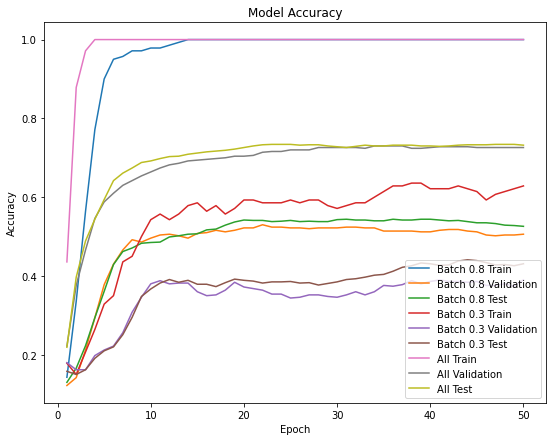

In [22]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_accs)
batch_results_1 = np.array(batch_accs_1)
all_results = np.array(all_accs)

x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
plt.plot(x, all_results[:, 0], label="All Train")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Here all accuracies are evaluated on the full-batch mode.这里所有的精度都是在全批次模式下评估的。

# 3 Cluster Sampling  
整群抽样

Instead of the neighbor sampling, we can use another approach, subgraph (cluster) sampling, to scale up GNN. This approach is proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)).  
除了邻居采样，我们可以使用另一种方法，子图（集群）采样，来扩展 GNN。 这种方法是在 Cluster-GCN (Chiang et al. (2019)) 中提出的。

In this section, we will implement vanilla Cluster-GCN and experiment with 3 different community partition algorithms.  
在本节中，我们将实现 vanilla Cluster-GCN 并试验 3 种不同的社区划分算法。

Notice that this section requires you have run the `Setup`, `GNN Model` and `Training and Testing` cells of the last section.  
请注意，本节要求您运行上一节的设置、GNN 模型和训练和测试单元。

## Setup

In [23]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./tmp', "Cora")

In [24]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partition the Graph into Clusters  
将图划分为簇

Here we use following three community detection / partition algorithms to partition the graph into different clusters:  
这里我们使用以下三种社区检测/划分算法将图划分为不同的集群：
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)  
（二等分）
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)  
贪婪模块化最大化

* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)  
鲁汶算法


To make the training more stable, we discard the cluster that has less than 10 nodes.  
为了使训练更加稳定，我们丢弃了少于 10 个节点的集群。

Let's first define these algorithms as DeepSNAP transformation on a graph.  
我们首先将这些算法定义为图上的 DeepSNAP 变换。

In [25]:
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = community_louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Louvain PreprocessLouvain 
预处理


In [26]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 7 communities
Each community has 355 nodes in average
Each community has 700 edges in average


## Louvain Training

In [27]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.0947, Train: 27.86%, Valid: 8.60% Test: 8.80%
Epoch: 02, Loss: 1.9719, Train: 23.57%, Valid: 15.00% Test: 13.30%
Epoch: 03, Loss: 2.9113, Train: 17.86%, Valid: 16.60% Test: 16.20%
Epoch: 04, Loss: 0.5427, Train: 19.29%, Valid: 18.40% Test: 18.40%
Epoch: 05, Loss: 2.8416, Train: 22.14%, Valid: 22.20% Test: 21.10%
Epoch: 06, Loss: 1.6135, Train: 28.57%, Valid: 22.20% Test: 22.60%
Epoch: 07, Loss: 1.3271, Train: 35.00%, Valid: 27.00% Test: 25.30%
Epoch: 08, Loss: 2.6578, Train: 37.14%, Valid: 24.20% Test: 25.80%
Epoch: 09, Loss: 2.2831, Train: 42.14%, Valid: 21.80% Test: 23.90%
Epoch: 10, Loss: 1.7932, Train: 45.71%, Valid: 20.80% Test: 22.40%
Epoch: 11, Loss: 0.2874, Train: 50.71%, Valid: 23.00% Test: 26.00%
Epoch: 12, Loss: 1.4824, Train: 62.14%, Valid: 25.20% Test: 28.90%
Epoch: 13, Loss: 1.0971, Train: 72.86%, Valid: 29.00% Test: 31.30%
Epoch: 14, Loss: 0.0553, Train: 80.00%, Valid: 31.40% Test: 34.40%
Epoch: 15, Loss: 0.5020, Train: 77.14%, Valid: 32.80% Test: 34.4

## Bisection Preprocess二分预处理

In [28]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 2 communities
Each community has 1354 nodes in average
Each community has 1395 edges in average


## Bisection Training

In [29]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.0474, Train: 27.14%, Valid: 10.00% Test: 10.10%
Epoch: 02, Loss: 1.0852, Train: 45.00%, Valid: 16.80% Test: 20.10%
Epoch: 03, Loss: 0.6088, Train: 60.71%, Valid: 29.40% Test: 32.90%
Epoch: 04, Loss: 0.4145, Train: 70.71%, Valid: 37.60% Test: 43.60%
Epoch: 05, Loss: 1.4667, Train: 78.57%, Valid: 51.20% Test: 54.60%
Epoch: 06, Loss: 0.9372, Train: 93.57%, Valid: 63.00% Test: 64.90%
Epoch: 07, Loss: 0.5096, Train: 97.14%, Valid: 66.80% Test: 70.40%
Epoch: 08, Loss: 0.1357, Train: 97.86%, Valid: 69.80% Test: 72.20%
Epoch: 09, Loss: 0.0882, Train: 97.86%, Valid: 69.60% Test: 73.10%
Epoch: 10, Loss: 0.1464, Train: 98.57%, Valid: 70.00% Test: 73.20%
Epoch: 11, Loss: 0.0949, Train: 97.86%, Valid: 71.20% Test: 73.40%
Epoch: 12, Loss: 0.0943, Train: 97.86%, Valid: 70.40% Test: 72.60%
Epoch: 13, Loss: 0.0457, Train: 97.86%, Valid: 70.40% Test: 72.70%
Epoch: 14, Loss: 0.0627, Train: 97.86%, Valid: 70.20% Test: 72.50%
Epoch: 15, Loss: 0.0663, Train: 99.29%, Valid: 70.40% Test: 72

## Greedy Preprocess贪婪的预处理

In [30]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 20 communities
Each community has 121 nodes in average
Each community has 222 edges in average


## Greedy Training

In [31]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 1.9926, Train: 17.86%, Valid: 17.20% Test: 15.90%
Epoch: 02, Loss: 2.3044, Train: 15.00%, Valid: 15.40% Test: 14.40%
Epoch: 03, Loss: 0.1602, Train: 15.00%, Valid: 15.40% Test: 14.10%
Epoch: 04, Loss: 0.2968, Train: 15.00%, Valid: 15.40% Test: 14.00%
Epoch: 05, Loss: 2.6297, Train: 15.71%, Valid: 15.20% Test: 13.60%
Epoch: 06, Loss: 3.9532, Train: 17.14%, Valid: 14.60% Test: 13.00%
Epoch: 07, Loss: 2.0893, Train: 18.57%, Valid: 11.80% Test: 10.70%
Epoch: 08, Loss: 3.9773, Train: 21.43%, Valid: 11.20% Test: 9.90%
Epoch: 09, Loss: 3.0095, Train: 22.14%, Valid: 11.40% Test: 10.50%
Epoch: 10, Loss: 2.1560, Train: 22.86%, Valid: 10.00% Test: 10.60%
Epoch: 11, Loss: 3.8736, Train: 25.00%, Valid: 10.20% Test: 10.60%
Epoch: 12, Loss: 1.4919, Train: 25.71%, Valid: 9.60% Test: 10.20%
Epoch: 13, Loss: 0.6975, Train: 28.57%, Valid: 12.60% Test: 13.50%
Epoch: 14, Loss: 1.5826, Train: 25.71%, Valid: 19.20% Test: 17.70%
Epoch: 15, Loss: 0.1827, Train: 22.14%, Valid: 20.00% Test: 17.6

## Full-Batch Training

In [32]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0881, Train: 66.43%, Valid: 29.40% Test: 31.00%
Epoch: 02, Loss: 1.1644, Train: 95.71%, Valid: 50.00% Test: 50.20%
Epoch: 03, Loss: 0.6545, Train: 100.00%, Valid: 65.40% Test: 66.90%
Epoch: 04, Loss: 0.3398, Train: 100.00%, Valid: 71.20% Test: 73.80%
Epoch: 05, Loss: 0.1817, Train: 100.00%, Valid: 72.00% Test: 75.60%
Epoch: 06, Loss: 0.0931, Train: 100.00%, Valid: 73.40% Test: 75.90%
Epoch: 07, Loss: 0.0596, Train: 100.00%, Valid: 74.80% Test: 76.60%
Epoch: 08, Loss: 0.0244, Train: 100.00%, Valid: 74.20% Test: 76.80%
Epoch: 09, Loss: 0.0140, Train: 100.00%, Valid: 75.40% Test: 76.70%
Epoch: 10, Loss: 0.0119, Train: 100.00%, Valid: 75.80% Test: 76.70%
Epoch: 11, Loss: 0.0063, Train: 100.00%, Valid: 76.20% Test: 76.80%
Epoch: 12, Loss: 0.0033, Train: 100.00%, Valid: 76.60% Test: 76.80%
Epoch: 13, Loss: 0.0014, Train: 100.00%, Valid: 76.00% Test: 76.40%
Epoch: 14, Loss: 0.

## Visualization

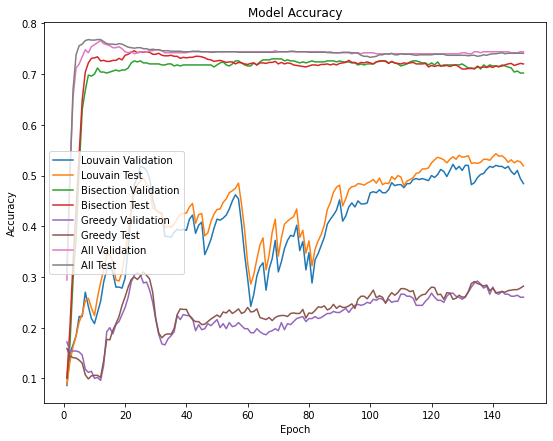

In [33]:
import numpy as np
from matplotlib import pyplot as plt

louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], label="Louvain Test")
plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], label="Bisection Test")
plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()